# MCMC Tutorial

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan

<br>

In this tutorial, we are going to introduce you to the basic concept of Markov Chain Monte Carlo (which we will from now on abbreviate as MCMC). If you want to see any of the code that was to long to put in the body of the notebook, please go to the code section.

## Linear Model and Parameter Estimation

<!-- In a real world application, we would have some observations of a system. In this tutorial, we will instead fit a two parameter **linear model** to some pseudo observations that we generate. We choose this approach to reduce the complexity of learning and understanding MCMC. It is also useful in understanding the assumptions made according to the structure of the observations. (**This part was adapted from MCMC chapter1**). -->


Let's say we have a linear model that models the amount of ice cream you will consume (where $y$ has units of pints) after going on a bike ride of length $x$ (where $x$ has units of miles). So the true process model, based on the unknown true values of the slope and intercept parameters, which we can call $\alpha^*$ and $\beta^*$, is:

$$y_{true} = \alpha^*x ~ + ~ \beta^*$$

We want to make this more realistic by incorporating some normally-distributed uncertainty, for instance, with mean $0$ and standard deviation $\sigma$.  Call these uncertain measurements $y_{meas}$:

$$y_{meas} = y_{true} ~ + ~ \epsilon = \alpha^*x ~ + ~ \beta^* ~ + ~ \epsilon$$

where $\epsilon \sim N(0, 1)$ is our normally-distributed measurement error. We now want to estimate $\alpha$ and $\beta$. Let us call $\hat{\alpha}$ and $\hat{\beta}$ our estimates of these parameters. They lead to a set of estimates of the response, $\hat{y}$:

$$\hat{y} = \hat{\alpha}x ~ + ~ \hat{\beta}$$

This technique is also known as the parameter estimation problem.

<br>

(**This part was adapted from in-class notebook MCMC and practicum**)

## Generate Synthetic Data

We can now generate some synthetic data using our linear model, as described above. To do this, we fix the $x$ distance values, at which we will estimate our ice cream intake, covering the range from $0$ to $9.9$ (inclusive), at intervals of $0.1$ miles. In this particular case, let $\alpha^* = 0.5$ and $\beta^* = 8$, which represent the true parameters for our linear model. (**This part was adapted from practicum**)

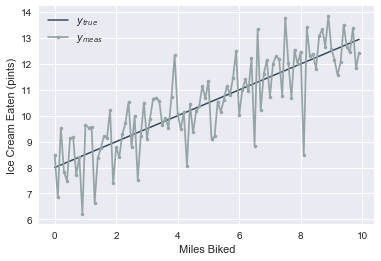

In [3]:
[(x_true, y_true), (x_meas, y_meas)] = generate_synthetic_data(astar=0.5, bstar=8, sigma=1, plot=True)

## Likelihood Function

The likelihood function describes the plausibility of a parameter value based on observations. Generally, we seek parameter values that maximize the likelihood function. For this example, since we know that the data is normally distributed with mean $0$ and standard deviation $\sigma$, we will use the product of normal distributions for each data point to represent the likelihood function:

$$L(y_{meas} \mid (\alpha, \beta)) = \prod_{i=1}^N f(\hat{y}_i-y_i \mid \mu=0, \sigma)$$

where $f(\hat{y}_i-y_i \mid \mu=0, \sigma)$ is a normal pdf evaluated at $\hat{y}_i - y_i$, with mean $0$ and standard deviation $\sigma$, and $\hat{y} = \alpha x + \beta$ (evaluated at the `x_true` points).

<br>

(**This part was adapted from in-class notebook MCMC**)

In [4]:
def likelihood(parameters, x_meas=x_meas, y_meas=y_meas, sigma=1):
    alpha, beta = parameters                                # unpack the parameters
    prod = 1                                                # initilize the product to 1
    for i in range(len(x_meas)):
        delta = alpha*x_meas[i] + beta - y_meas[i]          # the difference between the measured data and model data
        prod *= stats.norm.pdf(x=delta, loc=0, scale=sigma) # calculate the pdf (probability density function)
    return prod

## Prior Distributions

The prior probability is the probability that an event or observation will occur before taking into account new evidence. It is based on background information.

For this example, we could use a uniform prior distribution, for $\alpha \in [0,5]$ and $\beta \in [0,15]$. You may assume that $\alpha$ and $\beta$ are independent, so their prior distribution simplifies to $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$.

<br>

(**This part was adapted from practicum**)

In [5]:
def prior(parameters):
    alpha, beta = parameters                # unpack the parameters
    if 0 <= alpha <= 5 and 0 <= beta <= 15: # we want to make sure alpha and beta stay in the range.
        return (1/5)*(1/15)                 # if it is true then we return the product of their pdf
    else:
        return 0                            # if it is not true, we return 0

## Posterior Distribution/Posterior Score

To compute the acceptance probabilities for the Metropolis-Hastings algorithm, we need to know the posterior probability. The posterior probability is defined as being the probability that an event or observation will occur after taking into account all evidence and background information, in light of the uncertainties in both the parameters and the observations. Bayes' theorem defines the posterior probability as proportional to the likelihood of the observations given the parameters times the prior probability of the parameters:

$$\text{posterior distribution} = \pi((\alpha, \beta) \mid y_{meas}) = L(y_{meas} \mid (\alpha, \beta)) \times \pi(\alpha, \beta)$$

where $L(y_{meas} \mid (\alpha, \beta))$ is the likelihood function and $\pi(\alpha, \beta)$ is the prior distribution for $\alpha$ and $\beta$

The posterior distribution therefore summarizes information about the parameters based on the prior distribution and what the likelihood function says about more "likely" parameter values. The posterior therefore provides a range of parameter values, and says which values are more probable than others. 

In this analysis, you will work with the **log-probability distributions** for numerical stability reasons. That is, the probabilities involved may be very small, and computers may not be able to distinguish them from 0 in many cases.

In [6]:
def logpost(parameters, x_meas=x_meas, y_meas=y_meas, sigma=1):
    L = likelihood(parameters, x_meas, y_meas, sigma) # calculate the likelihood
    pi = prior(parameters)                            # calculate the prior
    return np.log(L*pi)                               # return the log of the posterior

## Couple examples of parameter fits

Provide examples of:

1. parameters that have high prior probability but low likelihood
2. parameters that have low prior probability but high likelihood
3. parameters that have bad both
4. parameters that have good both



(one figure with 4 linear fits on it, and legend)

In [7]:
max_prior = 0
min_likelihood = float("inf")
for a in tnrange(50):
    for b in range(50):
        parameters = (a, b)
        prior_probability = prior(parameters)
        current_likelihood = likelihood(parameters)
        if current_likelihood < min_likelihood and prior_probability > max_prior:
            best_params = parameters
            min_likelihood = current_likelihood
            max_prior = prior_probability
best_params

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

(0, 0)

In [8]:
min_likelihood

0.0

In [9]:
max_prior

0.013333333333333334

In [10]:
min_prior = float("inf")
max_likelihood = 0
for a in tnrange(50):
    for b in range(50):
        parameters = (a, b)
        prior_probability = prior(parameters)
        current_likelihood = likelihood(parameters)
        if current_likelihood > max_likelihood and prior_probability < min_prior:
            best_params = parameters
            max_likelihood = current_likelihood
            min_prior = prior_probability
best_params

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

(0, 8)

In [11]:
max_likelihood

5.899115798406527e-243

In [12]:
min_prior

0.013333333333333334

In [13]:
min_prior = float("inf")
min_likelihood = float("inf")
for a in tnrange(50):
    for b in range(50):
        parameters = (a, b)
        prior_probability = prior(parameters)
        current_likelihood = likelihood(parameters)
        if current_likelihood < min_likelihood and prior_probability < min_prior:
            best_params = parameters
            min_likelihood = current_likelihood
            min_prior = prior_probability
best_params

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

(0, 0)

In [14]:
min_likelihood

0.0

In [15]:
min_prior

0.013333333333333334

In [16]:
max_prior = 0
max_likelihood = 0
for a in tnrange(50):
    for b in range(50):
        parameters = (a, b)
        prior_probability = prior(parameters)
        current_likelihood = likelihood(parameters)
        if current_likelihood > max_likelihood and prior_probability > max_prior:
            best_params = parameters
            max_likelihood = current_likelihood
            max_prior = prior_probability
best_params

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

(0, 8)

In [17]:
max_likelihood

5.899115798406527e-243

In [18]:
max_prior

0.013333333333333334

## Definition of a Markov Chain

A Markov chain is "a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event." In other words, a random process $X_1, X_2, \ldots$ is a first-order Markov Chain if, for $i = 2, 3, \ldots$, the conditional density function satisfies

$$f(x_i \mid x_{i-1}, \ldots, x_1) = f(x_i \mid x_{i-1})$$

Markov chain models are widely used in statistical modeling, partly because they provide the simplest generalization of independent processes, partly because they are easy to estimate and partly because their proper- ties are well-understood. They can also be generalized to allow dependence on the most recent $k$ observations rather than just the most recent - this is a $k$th-order Markov chain. Because of the dependence of consecutive values in a Markov chain, the distribution of any future value $X_i + m$ is likely to depend on the current value $X_i$. However, for a wide class of Markov chains the dependence diminishes as m becomes large. In other words, a term in the sequence is influenced by the recent history of the series, but much less by its distant past. In this case the chain is said to have a stationary distribution, which is the distribution of $X_n$ as $n \rightarrow \infty$, the point being that the eventual stochastic properties of the process do not depend on the initial condition of the chain.

(**This part was adapted from wiki and Coles 2001**)

## Metropolis-Hastings Algorithm

Introduce as a way to formalize the notion that "Hey, *these* parameters were pretty good, let me propose some more parameters that 'look like' them!" (i.e., use a Markov chain)

The Metropolis-Hastings algorithm is as follows:

![](figs/metropolis_hastings_algo.png)

todo...

### Stationary Distribution

Todo...  review the fact that if you choose your transition probabilities (acceptance probabilities) in THIS special way, then the stationary distribution just happens to be the posterior distribution of your model parameters!

In [7]:
# First, let's set up some classes for our Metropolis-Hastings algorithm

class State: # This is the class for the state in Markov chain
    def __init__(self, state, value):
        self.state = state # The current state
        self.value = value # The corresponding log-posterior score for the current state

class ProblemMCMC: # This is the class to set the specific problem we want to solve by using Metropolis-Hastings algorithm
    def __init__(self, initial, logposterior, stepsize, x_meas, y_meas, sigma):
        self.current = initial # The initial state
        self.logpost = logposterior # The log-posterior function
        self.stepsize = stepsize # The step size to draw samples from multivariate normal distribution
        self.x = x_meas
        self.y = y_meas
        self.sigma = sigma

    def random_move(self): # This is the function to pick a random move by drawing from a multivariate normal distribution
        next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        return next_move, self.logpost(next_move, self.x, self.y, self.sigma)

In [25]:
# Let's code up the Metropolis-Hastings algorithm!

def mcmc(problem, n_iter, sequence_title):

    # want to keep growing these lists to track the parameter estimates
    alpha = [problem.current.state[0]]
    beta = [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    
    bar = pyprind.ProgBar(n_iter, title='\nRunning algorithm on '+sequence_title, bar_char='#')
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move()
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            # the proposed move is an improvement, so accept w.p. 1
            n_accept += 1
            alpha.append(nextMove[0])
            beta.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                alpha.append(nextMove[0])
                beta.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                alpha.append(alpha[-1])
                beta.append(beta[-1])
                lpost.append(lpost[-1])
        bar.update()

    return (alpha, beta, lpost, n_accept/S)

In [23]:
def sequences_generator(stepsize=[0.003, 0.02], n_iter=5000, x_meas=x_meas, y_meas=y_meas, sigma=1, logpost=logpost, m=3):
    problems = []
    burn_in = int(n_iter/2)
    bestfit = stats.linregress(x=x_meas, y=y_meas)
    slope, intercept = bestfit.slope, bestfit.intercept
    for i in range(m):
        theta = stats.multivariate_normal.rvs([bestfit.slope, bestfit.intercept], [0.01, 0.1])
        state = State(theta, logpost(theta, x_meas, y_meas, sigma))
        problems.append(ProblemMCMC(state, logpost, stepsize, x_meas, y_meas, sigma))
    alphas, betas, alphas_ana, betas_ana, ars = [], [], [], [], []
    print("Running MCMC algorithm", file=sys.stderr)
    for i in range(m):
        alpha, beta, lpost, ar = mcmc(problems[i], n_iter, 'Sequence '+str(i+1))
        alphas_ana.append(alpha[burn_in:])
        betas_ana.append(beta[burn_in:])
        alphas.append(alpha)
        betas.append(beta)
        ars.append(ar)
    return alphas, betas, alphas_ana, betas_ana, ars

In [10]:
def plot(alphas, betas):
    m = len(alphas)
    for i in range(m):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
        ax[0].plot(alphas[i])
        ax[0].set_xlabel("Iteration")
        ax[0].set_ylabel("Alpha Trace")
        ax[0].set_title("Sequence {}".format(i+1), fontsize=15)
        ax[1].plot(betas[i])
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("Beta Trace")
        ax[1].set_title("Sequence {}".format(i+1), fontsize=15)
        fig.savefig("traces/trace_sequence_"+str(i+1)+".png")
#         fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
#         ax.plot(alphas[i])
#         ax.plot(betas[i])
#         ax.set_xlabel("Iteration")
#         ax.set_ylabel("Traces")
#         ax.set_title("Sequence {}".format(i+1), fontsize=15)
#         fig.savefig("traces/trace_sequence_"+str(i+1)+".png")

In [11]:
n_iter = 4000
m = 4
interval = 100

In [26]:
alphas, betas, alphas_ana, betas_ana, ars = sequences_generator(n_iter=n_iter, m=m)

Running MCMC algorithm

Running algorithm on Sequence 1
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40

Running algorithm on Sequence 2
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:42

Running algorithm on Sequence 3
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:43

Running algorithm on Sequence 4
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:44


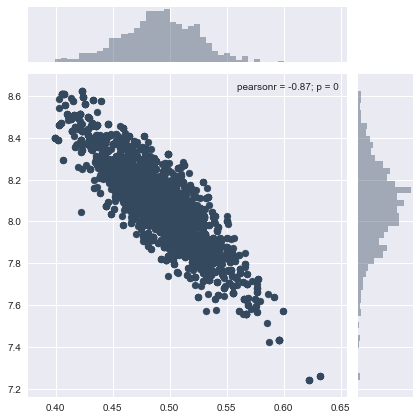

In [27]:
sns.jointplot(np.array(alphas[0]), np.array(betas[0]));

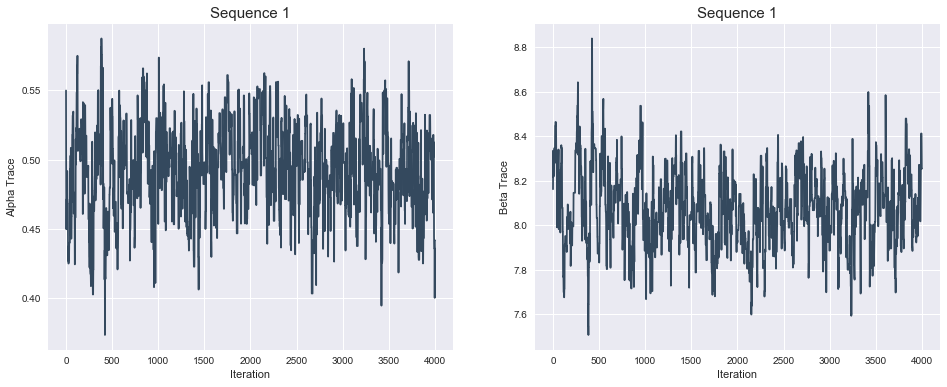

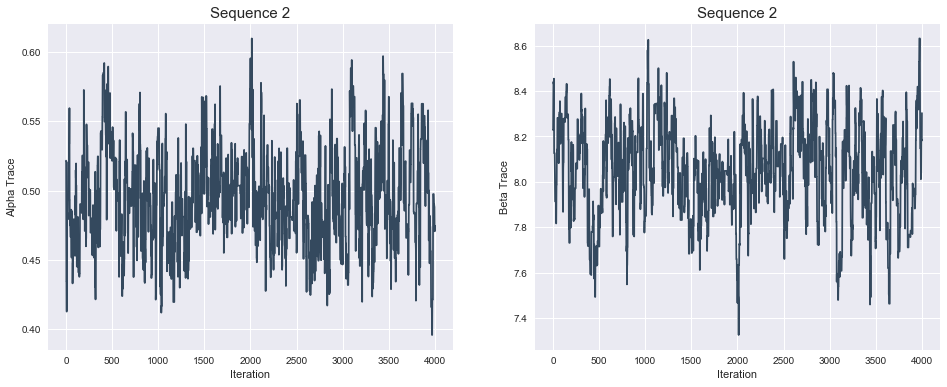

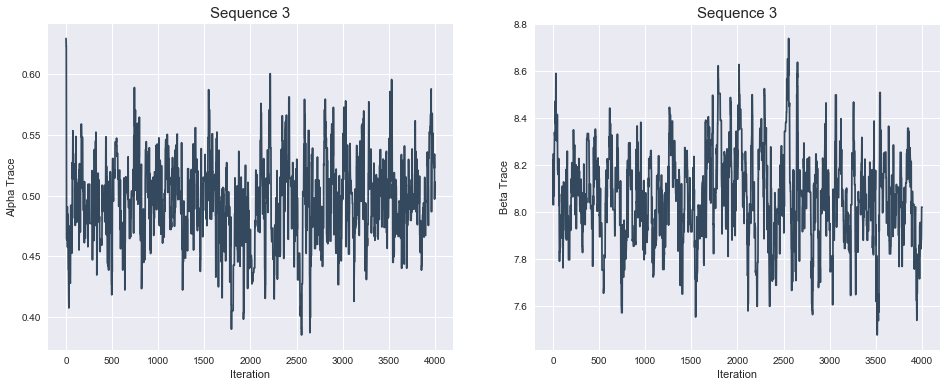

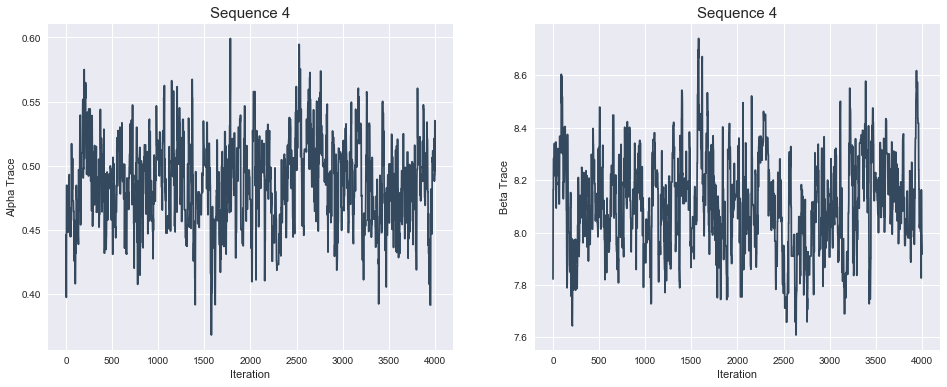

In [17]:
plot(alphas, betas)

## Convergence/Stationarity Diagnostics

The algorithm for the Gelman-Rubin Diagnostic is as follows:

![](figs/gelman_rubin_diag.png)

todo...

<!-- Steps for the **Gelman and Rubin diagnostic**: -->

<!-- - Run $m \geq 2$ chains of length $2n$ from different initial values
- Burn-in (Discard) the first n draws in each chain
- Calculate the within-chain and between-chain variance -->

<!-- $$ Between-chain \ variance = B =  \dfrac{n}{m-1}\sum\limits_{i=1}^m (\overline{\theta_i}-\overline{\overline{\theta}}) $$
$$ \overline{\overline{\theta}} =  \sum\limits_{i=1}^m \overline{\theta_i} $$ -->

<!-- $$ Within-chain \ variance = W = \dfrac{1}{m}\sum\limits_{i=1}^m s_{i}^{2}$$ -->

<!-- - Calculate the potential scale reduction factor. -->

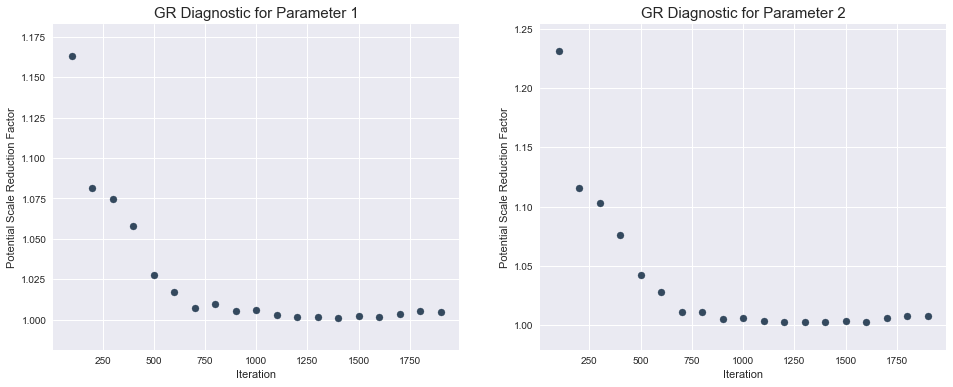

In [15]:
def GR_diag(alphas, betas, discard, m, interval=100):
    GR_alpha, GR_beta = [], []
    for n in range(100, discard, 100):
        sequences_a, sequences_b = [], []
        for i in range(m):
            sequences_a.append(alphas[i][:n])
            sequences_b.append(betas[i][:n])
        GR_alpha.append(cal_GR(sequences_a))
        GR_beta.append(cal_GR(sequences_b))
    return GR_alpha, GR_beta

def cal_GR(sequences):
    m, n, u, s = len(sequences), len(sequences[0]), [], []
    for i in range(m):
        u.append(np.mean(sequences[i]))
        s.append(np.var(sequences[i]))
    U, B, W = np.mean(u), 0, 0
    for i in range(m):
        B += (u[i]-U)**2
        W += s[i]
    B, W = (B*n)/(m-1), W/m
    return np.sqrt(((n-1)/n) + ((m+1)*B)/(m*n*W))

def plot_GR(GRs, interval=100):
    n_params, n_points = len(GRs), len(GRs[0])
    fig, ax = plt.subplots(nrows=1, ncols=n_params, figsize=(16,6))
    x = np.arange(interval, interval*(n_points+1), interval)
    for i in range(n_params):
        ax[i].scatter(x=x, y=GRs[i])
        ax[i].set_xlabel("Iteration")
        ax[i].set_ylabel("Potential Scale Reduction Factor")
        ax[i].set_title("GR Diagnostic for Parameter {}".format(i+1), fontsize=15)
    
GR_a, GR_b = GR_diag(alphas_ana, betas_ana, int(n_iter/2), 4)
plot_GR([GR_a, GR_b])

## Thinning

Todo ... (independence of samples)

In [18]:
# set up

alpha_burn = []
beta_burn = []
for i in range(m):
    alpha_burn.append(alphas_ana[i][600:])
    beta_burn.append(betas_ana[i][600:])

In [19]:
X = alpha_burn[1]
N = len(X)
Y = beta_burn[1]

In [20]:
def ACF(X, interval=100):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, N-100, 50):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
    return acf, x_range

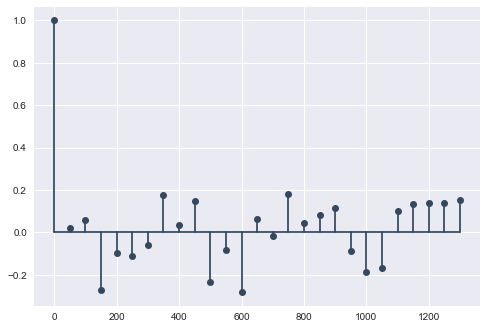

In [21]:
acf, x_ran = ACF(Y)
plt.stem(x_ran, acf)
plt.show()

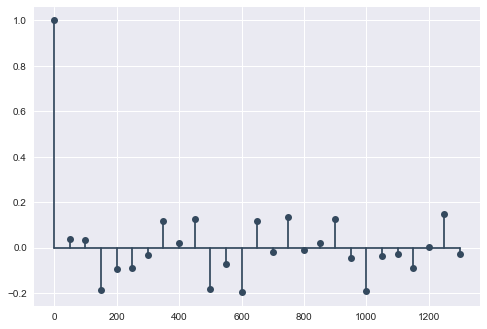

In [22]:
acf, x_ran = ACF(X)
plt.stem(x_ran, acf)
plt.show()

## Adaptive Metropolis Algorithm

A proper choice of a proposal distribution for MCMC methods, for example, the Metropolis-Hastings algorithm, is known to be a crucial factor for the convergence of the algorithm. In their paper, Haario etal introduce an adaptive Metropolis (AM) algorithm, where the Gaussian proposal distribution is updated during the process using all of the information accumulated so far. Due to the adaptive nature of the process, the AM algorithm is non-Markovian, but they establish that it has the correct ergodic properties.

We assume that our target distribution is supported on the subset $S \subset \mathcal{R}^d$, and that it has the (unscaled) density $\pi(x)$ with respect to the Lebesgue measure on $S$. With a slight abuse of notation, we shall also denote the target distribution $\pi$. We now explain how the AM algorithm works. Remember that the basic idea is to update the proposal distribution by using the knowledge we have so far acquired about the target distribution. Otherwise the definition of the algorithm is identical to the usual Metropolis process. Suppose, therefore, that at time $t - 1$ we have the sampled states $X_0, X_1, \ldots, X_{t - 1}$, where $X_0$ is the initial state. Then a candidate point $Y$ is sampled from the (asymptotically symmetric) proposal distribution $q_t(. \mid X_0, \ldots, X_{t - 1})$, which now depend on the whole history $(X_0, X_1, \ldots, X_{t - 1})$. The candidate point $Y$ is accepted with probability

$$
\alpha\left(X_{t - 1}, Y\right) = \text{min}\left(1, \frac{\pi(Y)}{\pi(X_{t - 1})}\right)
$$

(**This part was adapted from Haario etal 2001**)

In [23]:
eps = 0.0001

d = 2                                                                                                                                                                                                                                                                                                         

I_d = np.identity(d)

S_d = (2.4)**2/2

In [24]:
def update_cov(X, d=2, s_d=S_d, eps=0.0001, i_d=I_d):
    cov = np.cov(X)
    return s_d*cov + i_d*eps*s_d

In [25]:
class AdaptiveMCMC: # This is the class to set the specific problem we want to solve by using Metropolis-Hastings algorithm
    def __init__(self, initial, logposterior, stepsize, x_meas, y_meas, sigma, t0=100):
        self.current = initial # The initial state
        self.logpost = logposterior # The log-posterior function
        self.stepsize = stepsize # The step size to draw samples from mulitvariare normal distirbution
        self.x = x_meas 
        self.y = y_meas
        self.sigma = sigma
        self.t0 = t0
        
    def random_move(self, t, X): # This is the function to pick a random move by drawing from a multivariate normal distribution
        if (t <= self.t0):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.x, self.y, self.sigma)

In [26]:
def Adaptive_mcmc(problem, n_iter):
    
    # want to keep growing these lists to track the parameter estimates
    alpha = [problem.current.state[0]]
    beta = [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    
    for t in tnrange(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [alpha, beta])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            # the proposed move is an improvement, so accept w.p. 1
            n_accept += 1
            alpha.append(nextMove[0])
            beta.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                alpha.append(nextMove[0])
                beta.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                alpha.append(alpha[-1])
                beta.append(beta[-1])
                lpost.append(lpost[-1])

    return (alpha, beta, lpost, n_accept/S)

In [27]:
stepsize = [0.003, 0.02]
n_iter = 4000
sigma = 1
bestfit = stats.linregress(x=x_meas, y=y_meas)
initial_theta1 = stats.multivariate_normal.rvs([bestfit.slope, bestfit.intercept], [0.01, 0.1])
initial_state1 = State(initial_theta1, logpost(initial_theta1, x_meas, y_meas, sigma))
problem1 = AdaptiveMCMC(initial_state1, logpost, stepsize, x_meas, y_meas, sigma)

In [28]:
alphas, betas, lpost, ar = Adaptive_mcmc(problem1, 2000)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

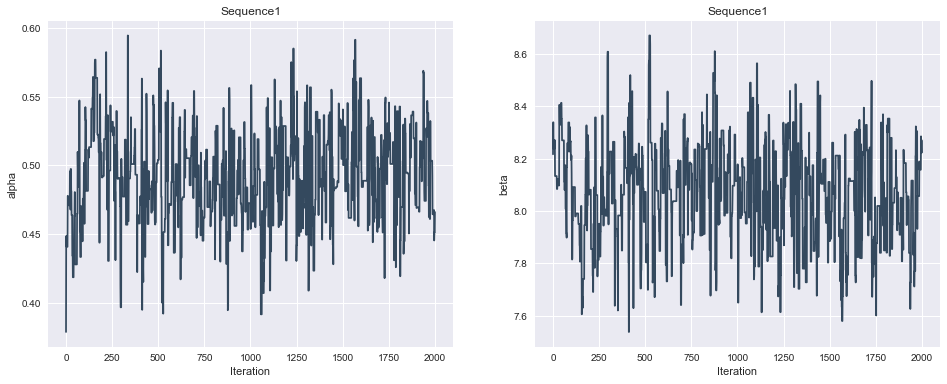

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(alphas)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('alpha')
ax[0].set_title('Sequence1')
ax[1].plot(betas)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('beta')
ax[1].set_title('Sequence1')
plt.show()

<br>
<br>
## Code

The seaborn palette we use is as follows:


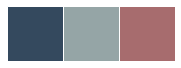

In [22]:
# All of our imports that we need
import pandas as pd
import numpy as np
import scipy.stats as stats
import pyprind
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn configuration
sns.set(style="darkgrid")
sns.set_context("notebook")
flatui = ["#34495e", "#95a5a6", "#a76c6e"]
print("The seaborn palette we use is as follows:")
sns.palplot(sns.color_palette(flatui))
sns.set_palette(sns.color_palette(flatui))
#sns.set_palette("PuBuGn_d")
# Run code to initialize typechecking for MyPy
%run -i typecheck.py
# Use 95% of the screen
from IPython.display import display, HTML, Latex
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Function to generate synthetic data (and plot it)
def generate_synthetic_data(astar, bstar, sigma, random_seed=1234, plot=False):
    np.random.seed(random_seed) # set the seed for random sampling.
    # the x and y values of our true model.
    x_true = np.arange(0,10,0.1)
    y_true = [astar*x + bstar for x in x_true]
    # the x and y values of our synthetic data set.
    x_meas = np.arange(0,10,0.1)
    y_meas = [stats.norm.rvs(loc=y, scale=sigma) for y in y_true]
    # plot if the user wants to
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
        ax.plot(x_true, y_true, lw=1.5, label="$y_{true}$")
        ax.plot(x_true, y_meas, label="$y_{meas}$", marker=".")
        ax.set_xlabel("Miles Biked")
        ax.set_ylabel("Ice Cream Eaten (pints)")
        ax.legend();
    # return the generated data
    return [(x_true, y_true), (x_meas, y_meas)]